In [77]:
import requests
import pandas as pd
# interactive pandas tables
%load_ext google.colab.data_table
import os
import shutil
try:
    import git
except ImportError:
    print("GitPython is not installed. Installing...")
    !pip install gitpython
    import git
import time
import joblib
import seaborn as sns
from sklearn.pipeline import make_pipeline

from sklearn.metrics import mean_squared_error, r2_score

from sklearn.metrics import classification_report
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC


from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

import warnings
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.under_sampling import TomekLinks, EditedNearestNeighbours
from imblearn.over_sampling import SMOTE
from sklearn.datasets import make_classification
from collections import Counter

from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression


# Filter out warnings
warnings.filterwarnings('ignore')

The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


In [78]:
def download_github_repository(repo_owner, repo_name, destination_folder):
    # create link to repository using the owner and name provided
    repository_url = f"https://github.com/{repo_owner}/{repo_name}"
    #clone the repository to the destination_folder

    if os.path.isdir(f'{destination_folder}/{repo_name}'):
      print(f"'{repo_name}' already exists.")
      shutil.rmtree(f'{destination_folder}/{repo_name}')
      #os.rmdir(f'{destination_folder}/{repo_name}')
      print(f"Folder {destination_folder}/{repo_name} deleted successfully.")

    try:
        #
        git.Git(destination_folder).clone(repository_url)
        print(f"Repository successfully downloaded to {destination_folder}")
    except git.exc.GitCommandError as e:
        print(f"Error downloading the repository: {e}")

## provide Github repository information
repo_owner = 'joel-day'
repo_name = 'Capstone'

## define where you want to put the data
destination_folder = "/content/github"

# create the destination folder
if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)

# run the definition
download_github_repository(repo_owner, repo_name, destination_folder)

# set working directry to that folder
os.chdir(f'{destination_folder}/{repo_name}')

# ensure the change happened
print("The working directory is:")
print(os.getcwd())

'Capstone' already exists.
Folder /content/github/Capstone deleted successfully.
Repository successfully downloaded to /content/github
The working directory is:
/content/github/Capstone


In [79]:
model_df = pd.read_excel("model_df.xlsx")
model_df['total_raised_by_population'] = model_df['total_raised_by_population'].round(3)
model_df['total_spent_by_population'] = model_df['total_spent_by_population'].round(3)
model_df['bach_high_school_ratio'] = model_df['bach_high_school_ratio'].round(3)

# target variable

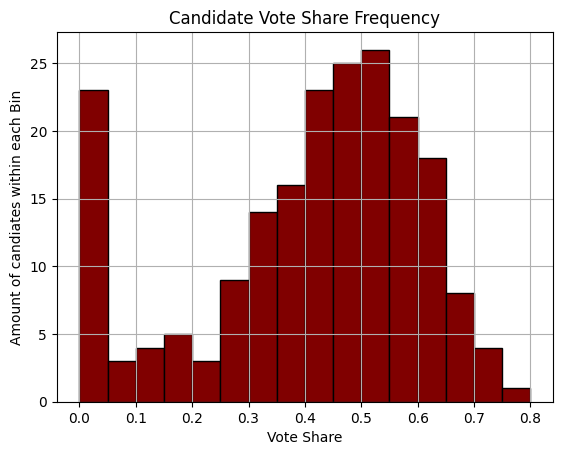

In [80]:
import matplotlib.pyplot as plt

vote_share = model_df['vote_share']

# Define the bin edges
bin_edges = [i * 0.05 for i in range(int(vote_share.min() / 0.05), int(vote_share.max() / 0.05) + 2)]

# Plot the histogram
plt.hist(vote_share, bins=bin_edges, edgecolor='black', color = 'maroon')
plt.xlabel('Vote Share')
plt.ylabel('Amount of candiates within each Bin')
plt.title('Candidate Vote Share Frequency')
plt.grid(True)
plt.savefig('histogram_vote_share.png')
plt.show()

In [81]:
def binarize_vote_share(value):
    if value > 0.5:
        return 1
    else:
        return 0

In [82]:
model_df['vote_share'] = model_df['vote_share'].apply(lambda x: binarize_vote_share(x))
model_df

,incumbent,party,number_of_comm,vote_share,total_raised_by_population,total_spent_by_population,bach_high_school_ratio,state_size,candidate_age,delayed_econ
0,0,L,1,0,0.525,0.557,2.538,0,0,1
1,1,R,1,1,1.403,1.339,0.962,2,2,0
2,1,D,4,0,2.876,2.787,2.807,3,1,0
3,1,D,3,1,2.112,1.474,2.212,2,3,0
4,1,R,2,1,1.053,1.044,1.471,5,0,0
...,...,...,...,...,...,...,...,...,...,...
198,1,O,1,0,2.920,2.855,3.837,3,2,4
199,1,R,3,1,1.144,1.106,0.931,2,2,5
200,0,D,1,0,4.140,4.180,0.931,2,3,5
201,0,D,1,0,0.070,0.067,2.737,1,1,5


# Seperate dependent variable (Vote Share)

In [83]:
X = model_df.drop(['vote_share'], axis=1)  # Features
y = model_df['vote_share']  # Target variable
y = pd.Series(y)

In [84]:
y.value_counts()

vote_share
0    127
1     76
Name: count, dtype: int64

In [85]:
num_cols = ['total_raised_by_population', 'total_spent_by_population', 'bach_high_school_ratio']
all_columns = X.columns.tolist()
cat_cols = [col for col in all_columns if col not in num_cols]
cat_cols

['incumbent',
 'party',
 'number_of_comm',
 'state_size',
 'candidate_age',
 'delayed_econ']

# Multi-Collinearity

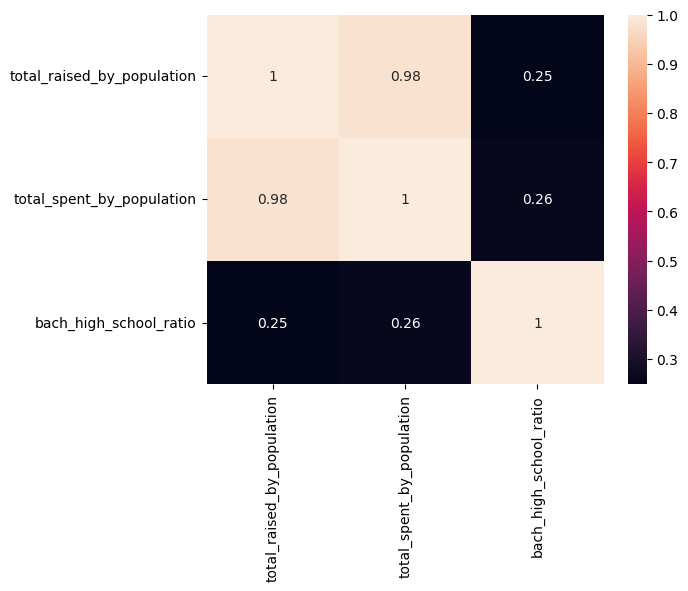

In [86]:
corr_matrix = X[num_cols].corr()
sns.heatmap(corr_matrix, annot=True)
plt.savefig('Numerical Feature Multi-collinearity.png')
plt.show()

# based on the above plot it is best to drop one of the two financial variables. I will drop amount spent

In [87]:
X = X.drop(['total_spent_by_population'], axis=1)  # Features

num_cols = ['total_raised_by_population', 'bach_high_school_ratio']
all_columns = X.columns.tolist()
cat_cols = [col for col in all_columns if col not in num_cols]
cat_cols

['incumbent',
 'party',
 'number_of_comm',
 'state_size',
 'candidate_age',
 'delayed_econ']

# Scaling
## SVM and neural networks are distance basaed and thus perform better when the features are scaled. Random forest and gradient boosting are robust to scaling.

In [88]:
from sklearn.preprocessing import StandardScaler

# Assuming X is your DataFrame
columns_to_scale = ['total_raised_by_population', 'bach_high_school_ratio']

scaler = StandardScaler()
X[columns_to_scale] = scaler.fit_transform(X[columns_to_scale])

In [ ]:
X

# One_Hot Encoding

In [ ]:
encoder = OneHotEncoder(drop='first')

# One-hot encode categorical columns
X_encoded = encoder.fit_transform(X[cat_cols])

# Convert encoded data to DataFrame
X_encoded_df = pd.DataFrame(X_encoded.toarray(), columns=encoder.get_feature_names_out(cat_cols))

# Concatenate with original DataFrame dropping original categorical columns
X_encoded_scaled = pd.concat([X.drop(columns=cat_cols), X_encoded_df], axis=1)

In [ ]:
X_encoded_scaled

,total_raised_by_population,bach_high_school_ratio,incumbent_1,party_L,party_O,party_R,number_of_comm_2,number_of_comm_3,number_of_comm_4,number_of_comm_5,...,state_size_4,state_size_5,candidate_age_1,candidate_age_2,candidate_age_3,delayed_econ_0,delayed_econ_1,delayed_econ_3,delayed_econ_4,delayed_econ_5
0,-0.407798,0.694517,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,-0.265339,-1.448428,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,-0.026339,1.060287,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,-0.150301,0.251243,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
4,-0.322128,-0.756322,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,-0.019200,2.460815,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
199,-0.307362,-1.490580,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
200,0.178750,-1.490580,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
201,-0.481623,0.965105,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


# PCA

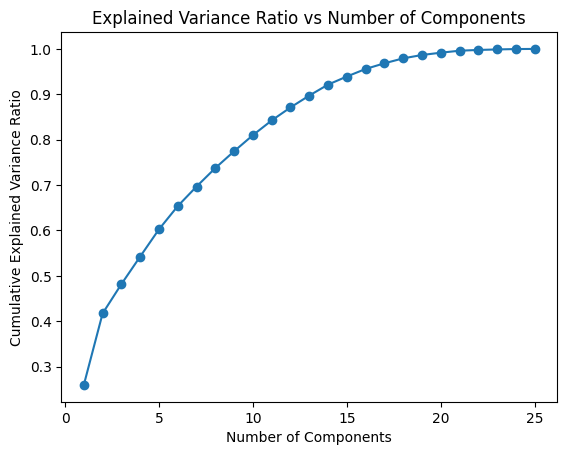

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

# Create PCA object
pca = PCA()

# Fit PCA on the scaled data
pca.fit(X_encoded_scaled)

# Get the principal components
components = pca.components_

# Get the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_


# Calculate cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Plot cumulative explained variance
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Explained Variance Ratio vs Number of Components')
plt.savefig('Explained Variance Ratio vs Number of Components.png')
plt.show()


# use the above grapgh to manually select the amount of pricincple component based on how much of the explained variecne you want to keep.

In [ ]:
n_components = 15  # You can change this number based on your preference

# Create PCA object with the selected number of components
pca = PCA(n_components=n_components)

# Fit PCA on the scaled data
pca.fit(X_encoded_scaled)

# Transform the data to the new coordinate system
X_pca = pca.transform(X_encoded_scaled)

In [76]:
X_pca.to_excel('pca.xlsx')

AttributeError: 'numpy.ndarray' object has no attribute 'to_excel'

# Split data into a test and train set

In [ ]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Linear Regression for Baseline

In [ ]:
linear_reg_model = LinearRegression()

# Fit the model to the training data
linear_reg_model.fit(X_train, y_train)

# Predict on the test data
lr_pred = linear_reg_model.predict(X_test)

model_name = "linear_regression_model.pkl"
joblib.dump(linear_reg_model, model_name)

['linear_regression_model.pkl']

# Create four simple non-linear models to compare with the models with tuned hyperparemtrs. The simple models will be prefered if the performance is close.

In [ ]:
classifiers = {
    'MLP': MLPClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'SVM': SVC()
}

In [ ]:
# Train and evaluate each classifier
for name, clf in classifiers.items():
    # Create a pipeline with preprocessing and the classifier
    pipe = Pipeline(steps=[('classifier', clf)])
    # Train the model
    pipe.fit(X_train, y_train)
    # Evaluate the model
    accuracy = pipe.score(X_test, y_test)
    print(f"{name} - Test Accuracy: {accuracy:.4f}")

MLP - Test Accuracy: 0.8537
Random Forest - Test Accuracy: 0.8537
Gradient Boosting - Test Accuracy: 0.8780
SVM - Test Accuracy: 0.8049


# Use cross validation and gridsearch to find the optimal parameters

In [ ]:
import warnings

# Filter out warnings
warnings.filterwarnings('ignore')
# Define classifiers with their respective hyperparameter grids
classifiers = {
  'MLP': (MLPClassifier(),
      {'classifier__hidden_layer_sizes': [(1,)],
        'classifier__activation': ['relu', 'logistic'],
        'classifier__solver': ['adam', 'lbfgs'],
        'classifier__alpha': [0.001, .005, .02]}),

    'Random Forest': (RandomForestClassifier(),
                      {'classifier__n_estimators': [35, 50, 60],
                       'classifier__max_depth': [5, 7]}),

    'Gradient Boosting': (GradientBoostingClassifier(),
                          {'classifier__n_estimators': [200, 300, 400],
                           'classifier__learning_rate': [.001, 0.01, 0.02],
                           'classifier__max_depth': [4]}),

    'SVM': (SVC(),
            {'classifier__C': [.1, 10],
             'classifier__kernel': ['linear', 'rbf']})
}

# Perform grid search for each classifier
for name, (clf, param_grid) in classifiers.items():
    # Create a pipeline with preprocessing and the classifier
    pipe = Pipeline(steps=[
                           ('classifier', clf)])

    # Perform grid search
    grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='f1_micro')
    grid_search.fit(X_train, y_train)

    # Print best parameters and score
    print(f"Best parameters for {name}: {grid_search.best_params_}")
    print(f"Best cross-validation score for {name}: {grid_search.best_score_:.4f}")

    # Evaluate the best model on test set
    test_score = grid_search.score(X_test, y_test)
    print(f"Test f1_score for {name}: {test_score:.4f}")

Best parameters for MLP: {'classifier__activation': 'logistic', 'classifier__alpha': 0.02, 'classifier__hidden_layer_sizes': (1,), 'classifier__solver': 'lbfgs'}
Best cross-validation score for MLP: 0.8210
Test f1_score for MLP: 0.7805
Best parameters for Random Forest: {'classifier__max_depth': 7, 'classifier__n_estimators': 60}
Best cross-validation score for Random Forest: 0.8157
Test f1_score for Random Forest: 0.8049
Best parameters for Gradient Boosting: {'classifier__learning_rate': 0.02, 'classifier__max_depth': 4, 'classifier__n_estimators': 300}
Best cross-validation score for Gradient Boosting: 0.8277
Test f1_score for Gradient Boosting: 0.9024
Best parameters for SVM: {'classifier__C': 0.1, 'classifier__kernel': 'linear'}
Best cross-validation score for SVM: 0.8581
Test f1_score for SVM: 0.8780


# create a pipeline with the final hyperparameters and preprocessing steps

In [ ]:
best_parameters = {
    'MLP': {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (1,), 'solver': 'lbfgs'},
    'Random Forest': {'max_depth': 7, 'n_estimators': 50},
    'Gradient Boosting': {'learning_rate': 0.02, 'max_depth': 4, 'n_estimators': 200},
    'SVM': {'C': 0.1, 'kernel': 'linear'}
}
from sklearn.metrics import classification_report
# Create pipelines using the best parameters
pipelines = {}
for name, params in best_parameters.items():
    if name == 'MLP':
        clf = MLPClassifier(**params)
    elif name == 'Random Forest':
        clf = RandomForestClassifier(**params)
    elif name == 'Gradient Boosting':
        clf = GradientBoostingClassifier(**params)
    elif name == 'SVM':
        clf = SVC(**params)

    pipelines[name] = make_pipeline(clf)

# Evaluate the pipelines
for name, pipeline in pipelines.items():
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    report = classification_report(y_test, y_pred, target_names=["class_0", "class_1"])  # Adjust target names accordingly

    print(f"Evaluation for {name}:")
    print(report)
# Loop through and save each model


Evaluation for MLP:
              precision    recall  f1-score   support

     class_0       0.82      0.90      0.86        20
     class_1       0.89      0.81      0.85        21

    accuracy                           0.85        41
   macro avg       0.86      0.85      0.85        41
weighted avg       0.86      0.85      0.85        41

Evaluation for Random Forest:
              precision    recall  f1-score   support

     class_0       0.69      0.90      0.78        20
     class_1       0.87      0.62      0.72        21

    accuracy                           0.76        41
   macro avg       0.78      0.76      0.75        41
weighted avg       0.78      0.76      0.75        41

Evaluation for Gradient Boosting:
              precision    recall  f1-score   support

     class_0       0.90      0.95      0.93        20
     class_1       0.95      0.90      0.93        21

    accuracy                           0.93        41
   macro avg       0.93      0.93      0.93 

In [ ]:
for name, pipeline in pipelines.items():
    pipeline.fit(X_train, y_train)

    # Save the model
    model_name = f"{name}_model.pkl"
    joblib.dump(pipeline, model_name)
    print(f"Saved {name} model as {model_name}")

Saved MLP model as MLP_model.pkl
Saved Random Forest model as Random Forest_model.pkl
Saved Gradient Boosting model as Gradient Boosting_model.pkl
Saved SVM model as SVM_model.pkl


# load the models into variables to prepare ensemble model

In [ ]:
model_name = "MLP_model.pkl"
mlp = joblib.load(model_name)
model_name = "Random Forest_model.pkl"
rf = joblib.load(model_name)
model_name = "SVM_model.pkl"
svm = joblib.load(model_name)
model_name = "Gradient Boosting_model.pkl"
gb = joblib.load(model_name)
model_name = "linear_regression_model.pkl"
lr = joblib.load(model_name)

# create ensemble model
## This is a weighted ensmeble voting model. The weights are chosen based on the above performance evaluation table. The models are prioritized in this order Gradient Boosting, Support Vector, MLP, then Random Forest.

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import f1_score
voting_clf = VotingClassifier(
    estimators=[('MLP', mlp), ('Random Forest', rf), ('SVM', svm), ('Gradient Boosting', gb)],
    voting='hard',  # You can use 'soft' if the models provide predict_proba method
    weights=[1, 1, 2, 3]  # Adjustable weights for each model
)

# Fit the voting classifier
voting_clf.fit(X_train, y_train)

# Evaluate the voting classifier
y_pred = voting_clf.predict(X_test)
f1 = f1_score(y_test, y_pred)

print("F1 score for the voting classifier:", f1)

# Save the voting classifier
joblib.dump(voting_clf, "voting_classifier.pkl")
print("Voting classifier saved as voting_classifier.pkl")

F1 score for the voting classifier: 0.9047619047619048
Voting classifier saved as voting_classifier.pkl


In [ ]:
model_name = "voting_classifier.pkl"
ensemble = joblib.load(model_name)

# Performance Evaluation

In [ ]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score

# Assuming you have predictions for each model
mlp_pred = mlp.predict(X_test)
rf_pred = rf.predict(X_test)
gb_pred = gb.predict(X_test)
svm_pred = svm.predict(X_test)
ensemble_pred = ensemble.predict(X_test)



# Calculating precision, recall, and F1-score for each model
mlp_precision = precision_score(y_test, mlp_pred)
mlp_recall = recall_score(y_test, mlp_pred)
mlp_f1 = f1_score(y_test, mlp_pred)

rf_precision = precision_score(y_test, rf_pred)
rf_recall = recall_score(y_test, rf_pred)
rf_f1 = f1_score(y_test, rf_pred)

gb_precision = precision_score(y_test, gb_pred)
gb_recall = recall_score(y_test, gb_pred)
gb_f1 = f1_score(y_test, gb_pred)

svm_precision = precision_score(y_test, svm_pred)
svm_recall = recall_score(y_test, svm_pred)
svm_f1 = f1_score(y_test, svm_pred)

ensemble_precision = precision_score(y_test, ensemble_pred)
ensemble_recall = recall_score(y_test, ensemble_pred)
ensemble_f1 = f1_score(y_test, ensemble_pred)

# Creating a DataFrame
data = {
    'Model': ['MLP', 'Random Forest', 'Gradient Boosting', 'SVM', 'Ensemble'],
    'Precision': [mlp_precision, rf_precision, gb_precision, svm_precision, ensemble_precision],
    'Recall': [mlp_recall, rf_recall, gb_recall, svm_recall, ensemble_recall],
    'F1-Score': [mlp_f1, rf_f1, gb_f1, svm_f1, ensemble_f1]
}

performance_metrics = pd.DataFrame(data)
performance_metrics.to_excel('model_evaluation.xlsx')

In [ ]:
performance_metrics

,Model,Precision,Recall,F1-Score
0,MLP,0.772727,0.809524,0.790698
1,Random Forest,0.888889,0.761905,0.820513
2,Gradient Boosting,0.904762,0.904762,0.904762
3,SVM,0.900000,0.857143,0.878049
4,Ensemble,0.904762,0.904762,0.904762


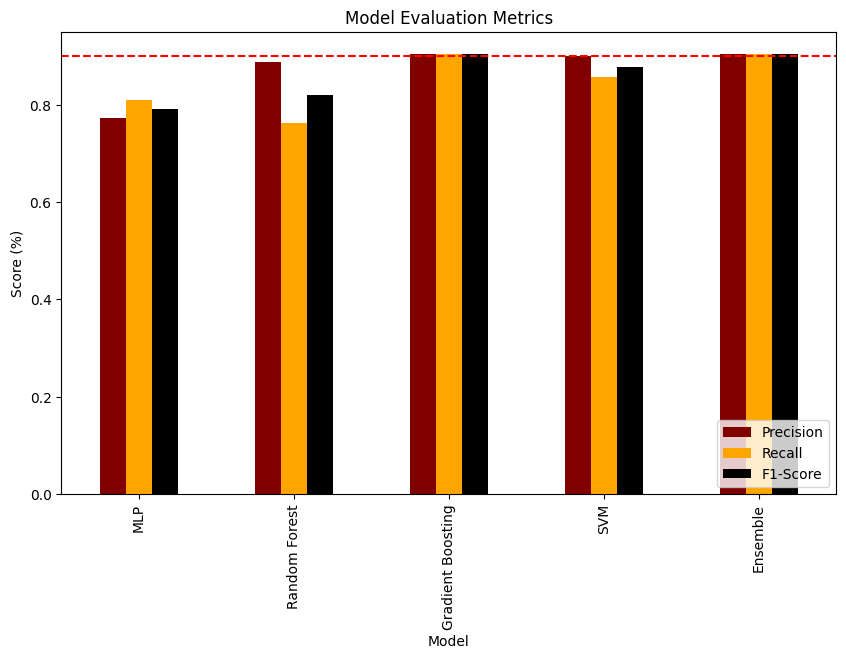

In [ ]:
# Set the index to 'Model' column for plotting
performance_metrics.set_index('Model', inplace=True)

# Plot the DataFrame

colors = ['maroon', 'orange', 'black']

# Plot the DataFrame
ax = performance_metrics.plot(kind='bar', figsize=(10, 6), color=colors)
plt.axhline(y=.90, color='red', linestyle='--')

ax.set_ylabel('Score (%)')
ax.set_xlabel('Model')
ax.set_title('Model Evaluation Metrics')
plt.legend(loc='lower right')
# Save the plot as a PNG file
plt.savefig('model_evaluation_bar_chart.png')

# Show the plot (optional)
plt.show()

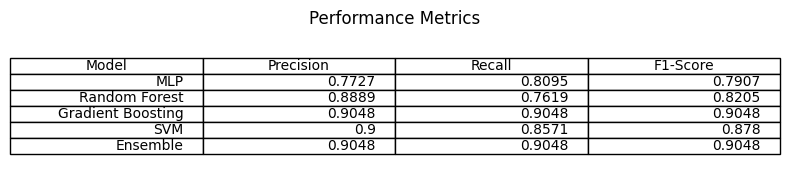

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming performance_metrics is your DataFrame containing performance metrics

# Round the precision, recall, and F1-score columns
performance_metrics[['Precision', 'Recall', 'F1-Score']] = performance_metrics[['Precision', 'Recall', 'F1-Score']].round(4)

# Set the index to the model names
performance_metrics_with_index = performance_metrics.reset_index()

# Create a plot from the DataFrame
plt.figure(figsize=(8, 2))  # Adjust size as needed
plt.table(cellText=performance_metrics_with_index.values, colLabels=performance_metrics_with_index.columns, loc='center')
plt.axis('off')  # Hide axis
plt.title('Performance Metrics')  # Add title
plt.tight_layout()  # Adjust layout
plt.savefig('Performance_metrics_table.png')  # Save as image
plt.show()
